In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
import ruptures as rpt
import numpy as np
from pathlib import Path
import seaborn as sns
import pandas as pd

import collections.abc as c
from scipy.interpolate import PchipInterpolator
import sys


sys.path.insert(0, Path('..').resolve().as_posix())
import gully_analysis
import gully_analysis.changepoint

sns.set_theme(style='whitegrid', context='talk')

In [11]:
# fpp = gpd.read_file(Path('../examples/data/mapped_profiles_samples.fgb'))
fpp = gpd.read_file(
    Path(
        '/media/alex/My Passport/FACULTATE_FOLDERE/STUDII/RAVENE_2025/GIS/saveni_aval/backcasted_mapped_profiles.fgb'
    )
)

<Axes: xlabel='Distance', ylabel='Elevation (m)'>

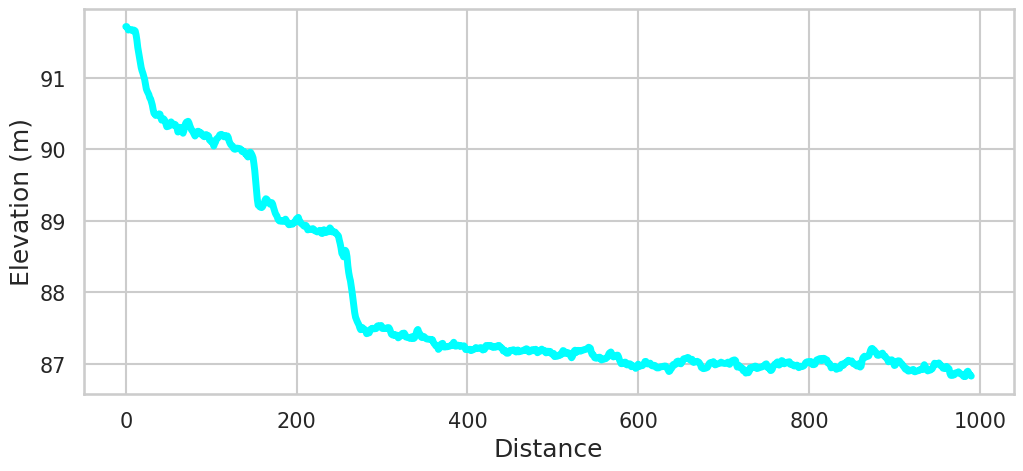

In [12]:
line = (
    fpp.loc[fpp['ID_LINE'] == 0]
    .sort_values(by='ID_POINT')
    .reset_index(drop=True)['Z']
)

line.plot(
    figsize=(12, 5),
    xlabel='Distance',
    ylabel='Elevation (m)',
    fontsize=15,
    linewidth=5,
    color='#00ffff',
)

In [30]:
def debug_estimation(
    profile: np.ndarray,
    profile_past: np.ndarray,
    profile_future: np.ndarray,
    changepoints: c.Sequence[int],
    out_file: Path,
    values_slice: slice = slice(0, 100, 1),
    true_values: np.ndarray | None = None,
):
    _, ax = plt.subplots(figsize=(12, 5))
    diff_forward = profile.shape[0] - profile_future.shape[0]
    diff_backward = profile.shape[0] - profile_past.shape[0]

    forecast_slice = slice(
        values_slice.start, values_slice.stop + abs(diff_forward)
    )
    backcast_slice = slice(
        values_slice.start, values_slice.stop - diff_backward
    )
    # ax.plot(
    #    list(range(diff_forward, profile.shape[0]))[forecast_slice],
    #    profile_future[forecast_slice],
    #    # c='#00ff00',
    #    label=r'forecasted flow profile - $t_1$',
    #    linewidth=3,
    #    c='#00ff00',
    #    ls='--',
    #    zorder=2,
    # )
    ax.plot(
        list(range(0, profile.shape[0]))[slice(0, values_slice.stop + 10, 1)],
        profile[slice(0, values_slice.stop + 10, 1)],
        c='#00ffff',
        label=r'reference flow profile - $t_0$',
        linewidth=5,
        zorder=3,
    )
    ax.plot(
        list(range(diff_backward, profile.shape[0]))[backcast_slice],
        profile_past[backcast_slice],
        # c='#00ff00',
        label=r'backcasted flow profile - $t_{-1}$',
        linewidth=5,
        c='#00ff00',
        ls='--',
        zorder=1,
    )
    for i, changepoint in enumerate(
        [point for point in changepoints if point <= values_slice.stop]
    ):
        ax.axvline(
            changepoint,
            color='black',
            ls='--',
            linewidth=3,
            label='changepoint' if i == 0 else None,
            zorder=4,
        )
    ax.legend(prop={'size': 15})
    ax.set_xlabel('Distance', size=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Elevation (m)', size=15)
    plt.tight_layout()
    plt.savefig(out_file, dpi=300)
    plt.show()


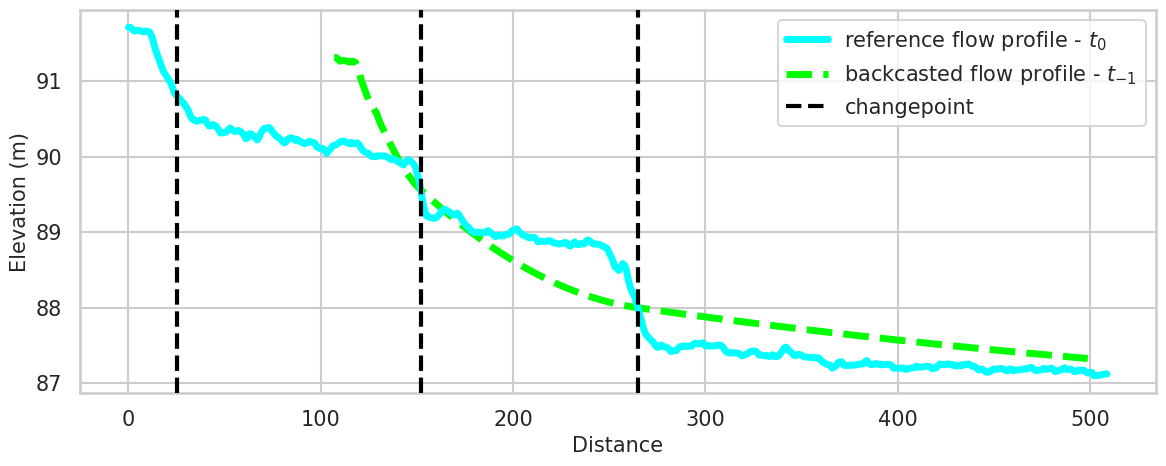

In [31]:
line = (
    fpp.loc[fpp['ID_LINE'] == 0]
    .sort_values(by='ID_POINT')
    .reset_index(drop=True)['Z']
)
changepoints = gully_analysis.changepoint.get_changepoints(
    line.values, penalty=20
)

new_profile_len = 991 - 884
estimated_backward = gully_analysis.changepoint.estimate_gully(
    line.values,
    line.values.copy()[new_profile_len:],
    changepoints,
    gully_cover=line.values - 0.4,
)

estimated_forward = gully_analysis.changepoint.estimate_gully(
    line.values,
    np.concatenate([[line.values[0] + 0.5] * new_profile_len, line.values]),
    changepoints,
)
# fig, ax = plt.subplots()

# ax.plot(estimated_backward)

debug_estimation(
    line.values,
    estimated_backward,
    estimated_forward,
    changepoints,
    # [],
    values_slice=slice(0, 500, 1),
    out_file=Path(
        '/media/alex/My Passport/FACULTATE_FOLDERE/STUDII/RAVENE_2025/t.png'
    ),
)


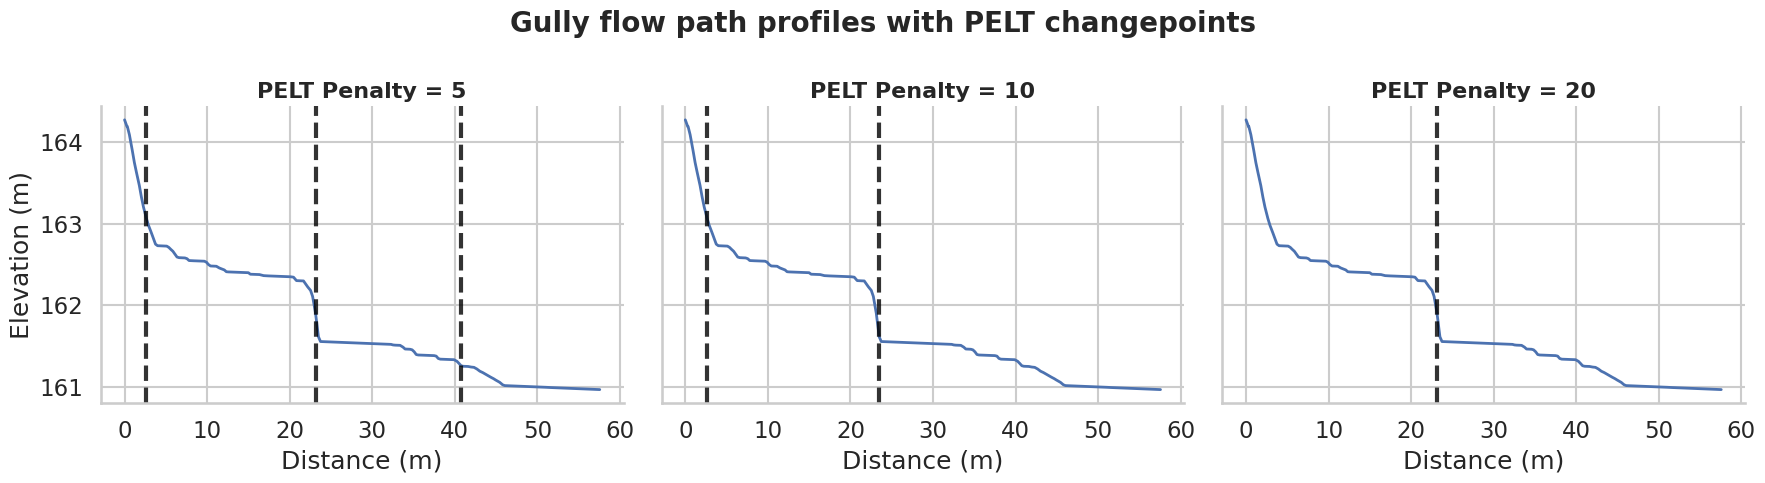

In [125]:
def pointplot_changepoints(data, **kwargs):
    x = data['Elevation (m)']
    penalty = data['PELT penalty'].iloc[0]
    distance = data['DISTANCE']

    # Get changepoints
    changepoints = gully_analysis.changepoint.get_changepoints(
        x.values, penalty
    )

    # Plot elevation profile
    sns.lineplot(x=distance, y=x, c='steelblue', linewidth=2, **kwargs)

    # Add changepoints (skip the last one if it's the end of the series)
    for i, cp in enumerate(changepoints[:-1]):
        plt.axvline(
            x=distance.iloc[cp],
            color='black',
            linestyle='--',
            linewidth=3,
            alpha=0.8,
            label='Changepoint' if i == 0 else None,  # only one legend label
        )

    # Optional: remove duplicate legends if grid adds them
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    if by_label:
        plt.legend(
            by_label.values(),
            by_label.keys(),
            loc='upper right',
            fontsize='small',
            frameon=False,
        )


# Filter and prepare data
line = (
    fpp.loc[fpp['ID_LINE'] == 10]
    .sort_values(by='ID_POINT')
    .reset_index(drop=True)
    .rename(columns={'Z': 'Elevation (m)'})
)

line_len = 200
penalties = [5, 10, 20]

df = pd.concat(
    [
        line.iloc[:line_len].set_index(pd.Index([penalty] * line_len))
        for penalty in penalties
    ]
).reset_index(names=['PELT penalty'])

# Create FacetGrid
g = sns.FacetGrid(
    df, col='PELT penalty', col_wrap=3, height=5, aspect=1.2, margin_titles=True
)

# Map plotting function
g.map_dataframe(pointplot_changepoints)

# Label axes and titles
g.set_axis_labels('Distance (m)', 'Elevation (m)')
g.set_titles(col_template='PELT Penalty = {col_name}', size=16, weight='bold')

# Adjust layout
g.figure.subplots_adjust(top=0.9)
g.figure.suptitle(
    'Gully flow path profiles with PELT changepoints',
    fontsize=20,
    weight='bold',
)
plt.tight_layout()

plt.show()
